In [12]:
%matplotlib inline

import numpy as np

import pandas as pd 
pd.__version__
from lmfit import Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
#import tikzplotlib
import re
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF
from rdflib.plugins.sparql import prepareQuery

from shapely import Polygon, Point
from matolab_tools import annotate_csv_uri, csvw_to_rdf , create_mapping, get_joined_rdf 

#fetch sematic data and query for datasets and rois
PMD_CO=Namespace("https://w3id.org/pmd/co/")
OME=Namespace("https://github.com/Mat-O-Lab/OmeroExtractor/raw/main/ome.ttl#")
QUDT = Namespace("http://qudt.org/schema/qudt/")
OA = Namespace("http://www.w3.org/ns/oa#")
QUDT_UNIT_URL = 'https://raw.githubusercontent.com/qudt/qudt-public-repo/main/vocab/unit/VOCAB_QUDT-UNITS-ALL-v2.1.ttl'
QUNIT = Namespace("http://qudt.org/vocab/unit/")

units_graph = Graph()
units_graph.parse(QUDT_UNIT_URL, format='turtle')


def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

def get_unit_symbol(qudt_unit):
  return str(units_graph.value(qudt_unit,QUDT.symbol))

def get_histogram(y, start=0.0, end=None, bin_width=1.0,x_label='x',plot_result=False) -> pd.DataFrame:
    #num_bins=int((max_x-min_x)/bin_width)
    y_label="normalized count"
    if not end:
       end=max(y)
    # default half open edges, last bin is regular bin_with edge to max(x)
    bin_edges=np.arange(start, end, bin_width)
    count, bin_edges= np.histogram(y,bins=bin_edges)
    
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist=pd.DataFrame({'center': bin_centers, 'count': count})
    # Poisson noise: \sigma_1=\sqrt(N_i(1−N_i/N)) for big enough N_i -> =\sqrt(N_i)
    hist['err']=np.sqrt(hist['count']*(1-hist['count']/hist['count'].sum())) #np.sqrt(hist['count'])
    hist['norm']=hist['count']/hist['count'].sum()
    hist['norm_err']=hist['err']/hist['count'].sum()
    if plot_result:
        plt.figure()
        plt.bar(hist['center'], hist['count'], width=bin_width, alpha=0.5,align='center')
        plt.xlabel(x_label)
        plt.ylabel('count')
        plt.show()
    return hist

#log distrubition fumction
def rock(x, rm, sigma):
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

meta=Graph()
meta.parse("https://raw.githubusercontent.com/BAMresearch/DF-TEM-PAW/main/detection_runs-joined.ttl",format='turtle')
#meta.parse("./detection_runs-joined.ttl")
#add inverse relations
for s,p,o in meta.triples((None,PMD_CO.isResourceOf,None)):
   meta.add((o,PMD_CO.resource,s))
for s,p,o in meta.triples((None,PMD_CO.characteristic,None)):
   meta.add((o,PMD_CO.characteristicOf,s))
#meta.serialize('test.ttl')

In [13]:
def fit_ellipse(polygon, method: int=1):
    # Convert polygon to NumPy array
    coords = np.array(polygon.exterior.coords)
    # Compute centroid of polygon
    #centroid=Point(polygon.centroid)
    x=coords[:,0]
    y=coords[:,1]
    x=x[:,None]
    y=y[:,None]
    D=np.hstack([x*x,x*y,y*y,x,y,np.ones(x.shape)])
    S=np.dot(D.T,D)
    C=np.zeros([6,6])
    C[0,2]=C[2,0]=2
    C[1,1]=-1
    E,V=np.linalg.eig(np.dot(np.linalg.inv(S),C))
    if method==1:
        n=np.argmax(np.abs(E))
    else:
        n=np.argmax(E)
    a=V[:,n]
    #-------------------Fit ellipse-------------------
    b,c,d,f,g,a=a[1]/2., a[2], a[3]/2., a[4]/2., a[5], a[0]
    num=b*b-a*c
    cx=(c*d-b*f)/num
    cy=(a*f-b*d)/num
    angle=0.5*np.arctan(2*b/(a-c))*180/np.pi
    up = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    down1=(b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    down2=(b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    a=np.sqrt(abs(up/down1))
    b=np.sqrt(abs(up/down2))
    major_axis=a
    minor_axis=b
    return cx, cy, major_axis, minor_axis, angle

def fit_log_distribution(x, y, weights=None, x_min=None, x_max=None, y_max=0.0, bin_width=1.0, label='distribution', x_label=r"$x$", y_label=r"probability density", filename='fit_log_distribution.png', save_plot=False) -> dict:
   results=dict()
   if not x_min:
      x_min=0
   if not x_max:
      x_max=max(x)
   x_sim=np.linspace(x_min,x_max,300)
   #https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
   fit=pd.DataFrame(columns=('x','y','dely'))
   model = Model(rock)
   #params = model.make_params(sigma=3.0, rm=1.0)
   params = Parameters()
   #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
   params.add('sigma', value=1, min=0.1, max=100.0,vary=True)
   params.add('rm', value=5.0, min=0.5,max=100, vary=True)
   result = model.fit(y, params, x=x,weights=weights)
   print(result.fit_report())
   
   fit['x']=x_sim
   fit['y']=model.eval(x=x_sim, params=result.params)
   fit['dely'] = result.eval_uncertainty(x=x_sim)
   #results['chi squared']=result.chisqr
   results['chi squared']=np.sum(result.residual**2/result.best_fit)
   results['Rsquared']=result.rsquared
   # results.at[key,'amplitude']=result.params['amp'].value
   # results.at[key,'amplitude stderr']=result.params['amp'].stderr
   results['rm']=result.params['rm'].value
   results['rm stderr']=result.params['rm'].stderr
   results['sigma']=result.params['sigma'].value
   results['sigma stderr']=result.params['sigma'].stderr
   results['ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
   results['ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
   results['n_bins']=len(x)
   results['dof']=len(x)-2 #2 nbins - free varaiables
   results['chi squared re']=results['chi squared']/results['dof']
   
   results['start']=x_min
   results['end']=x_max
   results['bin_width']=bin_width
   results['fit']=fit
   fig=plt.figure()
   plt.tight_layout()
   ax=plt.axes()
   #ax.set_facecolor((.94, .94, .94))
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   #ax.yaxis.grid(True, color='#EEEEEE')
   #ax.xaxis.grid(False)
   #plt.title(r"log normal fit $r_m={:.2f}\pm{:.2f}$, $\sigma={:.2f}\pm{:.2f}$".format(result.params['rm'].value,result.params['rm'].stderr,result.params['sigma'].value,result.params['sigma'].stderr))
   bars=ax.bar(x, y, width=bin_width, alpha=0.5,align='center', linewidth=0.2, edgecolor='gray', label=label)
   plt.plot(fit['x'], fit['y'], label=r"Log-normal fit: $r_m={:.2f}\pm{:.2f}$, $\sigma={:.2f}\pm{:.2f}$, $R^2={:.2f}$".format(result.params['rm'].value,result.params['rm'].stderr,result.params['sigma'].value,result.params['sigma'].stderr,results['Rsquared']))
   plt.fill_between(fit['x'], fit['y']-fit['dely'],
         fit['y']+fit['dely'], color='#888888',alpha=0.3)
   plt.xlabel(x_label)
   plt.xlim(left=x_min,right=x_max)
   plt.ylim(bottom=0)
   bar_color = bars[0].get_facecolor()
   # for bar in bars:
   #    ax.text(
   #       bar.get_x() + bar.get_width() / 2,
   #       bar.get_height(),
   #       round(bar.get_height(), 1),
   #       horizontalalignment='center',
   #       color=bar_color,
   #       weight='bold'
   #    )
   if y_max:
      plt.ylim(top=y_max)
   
   #plt.xticks(x)
   plt.ylabel(y_label)
   plt.legend()
   plt.show()
   if save_plot:
      fig.savefig(filename)
   plt.close(fig)   
   return results


# Distribution Formula
$$X = \frac{1}{\sqrt{2 \pi} x \sigma} \exp{\left(-\frac{(\ln{x}-\ln{r_m})^2}{2 \sigma^2}\right)}$$

In [14]:
#fetching data from joined graph
q = prepareQuery(
    """
    SELECT ?ome_image ?ome_rois ?specimen_label ?chartype ?charvalue ?charunit WHERE 
    {
          ?image rdf:type co:Image ;
            co:resource+/rdf:first ?ome_image.
          ?image_process co:output ?image ;
            co:nextProcess ?analysis_process ;
            co:input ?specimen .
          ?analysis_process co:output ?rois.
          ?rois co:resource+/rdf:first ?ome_rois.
          ?creep_process co:nextProcess ?image_process;
            co:input [ a ?chartype;
              co:resource / qudt:value ?charvalue;
              co:resource / qudt:unit ?charunit].
          ?specimen co:characteristic [ a co:SpecimenName;
            co:resource / oa:hasBody / oa:value ?specimen_label]
    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME, "rdf": RDF, "oa": OA, "qudt": QUDT}
)

qres = meta.query(q)
print(list(qres)[:10])
df = pd.DataFrame(qres, columns =["ome_image", "ome_rois", "specimen_label", "parameter", "value", "unit"])
#remove rows names individual
df = df[df["parameter"] != URIRef("http://www.w3.org/2002/07/owl#NamedIndividual")]
result=df.iloc[:,0:3]#.set_index("ome_image")
params=df.loc[:,['ome_image',"parameter","value", "unit"]].set_index(["ome_image","parameter"])
params=params.unstack().reset_index()
params.columns = [' '.join((str2.rsplit('/',1)[-1],str1)).strip() for (str1,str2) in params.columns.values]

result.set_index('ome_image',inplace=True)
params.set_index('ome_image',inplace=True)
result=pd.concat([result, params.reindex(result.index)], axis=1).drop_duplicates()
#result['AgingTemperature unit symbol']=result['AgingTemperature unit'].map(get_unit_symbol)
result
result['dataset']= "T"+result['AgingTemperature value'].astype(str)+result['AgingTemperature unit'].map(get_unit_symbol)+'_'\
  "D"+result['AgingTime value'].astype(str)+result['AgingTime unit'].map(get_unit_symbol)+'_'\
  "S"+result['CreepStress value'].astype(str)+result['CreepStress unit'].map(get_unit_symbol)
data=result.reset_index().set_index(['dataset','ome_image']).to_dict('index')
data.keys()
data_dict=dict()
#data_dict={ dataset: {} for (dataset, index) in data.keys()}
for (dataset, index),value in data.items():
  if dataset not in data_dict.keys():
    data_dict[dataset]=dict()
  data_dict[dataset][index]=value
data_dict

[(rdflib.term.URIRef('https://metadata.omero.matolab.org/api/image/83'), rdflib.term.URIRef('https://metadata.omero.matolab.org/api/rois/83'), rdflib.term.Literal('190C_1000h_1', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')), rdflib.term.URIRef('http://www.w3.org/2002/07/owl#NamedIndividual'), rdflib.term.Literal('190.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')), rdflib.term.URIRef('http://qudt.org/vocab/unit/DEG_C')), (rdflib.term.URIRef('https://metadata.omero.matolab.org/api/image/83'), rdflib.term.URIRef('https://metadata.omero.matolab.org/api/rois/83'), rdflib.term.Literal('190C_1000h_1', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')), rdflib.term.URIRef('https://w3id.org/pmd/co/AgingTemperature'), rdflib.term.Literal('190.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')), rdflib.term.URIRef('http://qudt.org/vocab/unit/DEG_C')), (rdflib.term.URIRef('https://metadata.omero.ma

{'T190.0°C_D1000.0hr_S0MPa': {rdflib.term.URIRef('https://metadata.omero.matolab.org/api/image/83'): {'ome_rois': rdflib.term.URIRef('https://metadata.omero.matolab.org/api/rois/83'),
   'specimen_label': rdflib.term.Literal('190C_1000h_1', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')),
   'AgingTemperature value': rdflib.term.Literal('190.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')),
   'AgingTime value': rdflib.term.Literal('1000.0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')),
   'CreepStress value': rdflib.term.Literal('0', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#integer')),
   'AgingTemperature unit': rdflib.term.URIRef('http://qudt.org/vocab/unit/DEG_C'),
   'AgingTime unit': rdflib.term.URIRef('http://qudt.org/vocab/unit/HR'),
   'CreepStress unit': rdflib.term.URIRef('http://qudt.org/vocab/unit/MegaPA')},
  rdflib.term.URIRef('https://metadata.omero.matolab.org/api/image/8

In [15]:
#fetch physical size of images
q = prepareQuery(
    """
    SELECT ?image ?sizex_value ?sizex_unit ?sizey_value ?sizey_unit WHERE 
    {
        ?image ome:relates_to / ome:physicalSizeX ?sizex ;
            ome:relates_to / ome:physicalSizeY ?sizey.
        ?sizex qudt:value ?sizex_value;
            qudt:unit ?sizex_unit.
        ?sizey qudt:value ?sizey_value;
            qudt:unit ?sizey_unit.
    }
    """
    ,
    initNs = { "qudt": QUDT, "ome": OME}
)
#df = pd.DataFrame(qres, columns =["image", "ome_image", "image_ds", "ome_image_ds", "rois", "ome_rois"])
pysicalsizes=dict()
for dataset, content in data_dict.items():
    images_graph=Graph()
    for image in content.keys():
        print(image)
        images_graph.parse(image,format='json-ld')
    qres = images_graph.query(q)
    df=pd.DataFrame(qres,columns =["image","sizex", "xunit", "sizey", "yunit"])
    df.set_index('image',inplace=True)
    df.index = df.index.map(str)
    pysicalsizes[dataset]=df
#pysicalsizes

https://metadata.omero.matolab.org/api/image/83
https://metadata.omero.matolab.org/api/image/84
https://metadata.omero.matolab.org/api/image/81
https://metadata.omero.matolab.org/api/image/82
https://metadata.omero.matolab.org/api/image/85
https://metadata.omero.matolab.org/api/image/74
https://metadata.omero.matolab.org/api/image/75
https://metadata.omero.matolab.org/api/image/76
https://metadata.omero.matolab.org/api/image/77
https://metadata.omero.matolab.org/api/image/78
https://metadata.omero.matolab.org/api/image/79
https://metadata.omero.matolab.org/api/image/80
https://metadata.omero.matolab.org/api/image/267
https://metadata.omero.matolab.org/api/image/268
https://metadata.omero.matolab.org/api/image/269
https://metadata.omero.matolab.org/api/image/256
https://metadata.omero.matolab.org/api/image/257
https://metadata.omero.matolab.org/api/image/252
https://metadata.omero.matolab.org/api/image/258
https://metadata.omero.matolab.org/api/image/253
https://metadata.omero.matolab.o

In [16]:
# reshape countour data and calculate the polygon properties centroid, area, radius
from matplotlib.patches import Ellipse

poly_dict=dict()
for dataset, content in data_dict.items():
    contour_list=list()
    print("accessing {} with {} rois.".format(dataset,len(content)))
    rois=list()
    for image,record in content.items():
        image_str=str(image)
        shape_graph=Graph()
        rois.append(record['ome_rois'])
        shape_graph.parse(record['ome_rois'],format='json-ld')
        polygons_meta=shape_graph.subjects(RDF.type,OME.Polygon)
        #image_id=record['ome_rois'].rsplit('/',1)[-1]
        #reshape data
        contour_data=[shape_graph.value(polygon,OME.points).split(' ') for polygon in polygons_meta]
        contour_data=[[point.split(',')for point in contour] for contour in contour_data]
        #to pysical coords
        scale=[float(pysicalsizes[dataset].loc[image_str]['sizex']),float(pysicalsizes[dataset].loc[image_str]['sizey'])]
        contour_data=[np.array(contour).astype('float64')*scale for contour in contour_data]
        #print("{} contours with scale {} for {} image".format(len(contour_data),scale,image))
        contour_list+=contour_data
    #print(np.array(contour_data[0]))
    #calc polygon charakteristics
    fig, ax = plt.subplots()
    polygon_props=list()
    polygons=[Polygon(contour) for contour in contour_list]
    i=0
    for polygon in polygons:
        if polygon.area>1.0:
            # calculate the distance from the centroid to each vertex
            centroid=Point(polygon.centroid)
            distances = [centroid.distance(Point(vertex)) for vertex in polygon.exterior.coords]
            # calculate the mean radius of the polygon, as mean of distance from centrois to exterior points
            mean_radius_edge = sum(distances) / len(distances)
            mean_radius_circle_area = np.sqrt(polygon.area/np.pi)
            cx, cy, major_axis, minor_axis, orientation=fit_ellipse(polygon)
            aspect_ratio=major_axis/minor_axis
            x,y = polygon.exterior.xy
            ax.plot(x,y,linewidth=0.5)
            if aspect_ratio<3:
                color='green'
            else:
                color='red'

            e=Ellipse((centroid.x, centroid.y), width=major_axis*2., height=minor_axis*2., angle=orientation, alpha=0.7, color=color)
            ax.add_patch(e)
            #print(major_axis,minor_axis,orientation)
            polygon_props.append({'area': polygon.area, 'centroid': polygon.centroid, 'mean_radius_edge_distance': mean_radius_edge, 'mean_radius_circle_area': mean_radius_circle_area, 'radius_minor_axis_ellipsis': minor_axis, 'aspect_ratio': aspect_ratio, 'orientation': orientation})
            i+=1
    
    fig.savefig("./polygons/{}.png".format(dataset))
    plt.close()
    df=pd.DataFrame(polygon_props)
    filename="./polygons/{}.csv".format(dataset)
    df.to_csv(filename)
    print('characterized {} polygons'.format(len(df)))
    poly_dict[dataset]={"dataframe": df, 'rois': rois}


accessing T190.0°C_D1000.0hr_S0MPa with 12 rois.
characterized 563 polygons
accessing T190.0°C_D8760.0hr_S0MPa with 19 rois.
characterized 540 polygons
accessing T23.0°C_D0.0hr_S0MPa with 12 rois.
characterized 1518 polygons
accessing T190.0°C_D25000.0hr_S0MPa with 21 rois.
characterized 363 polygons
accessing T190.0°C_D2500.0hr_S0MPa with 17 rois.
characterized 621 polygons
accessing T190.0°C_D250.0hr_S0MPa with 11 rois.
characterized 722 polygons
accessing T190.0°C_D5000.0hr_S0MPa with 23 rois.
characterized 1008 polygons


calculating distribution of T190.0°C_D1000.0hr_S0MPa with 563 polygons.
[0.01634583 0.01880319 0.01535421 0.01386637 0.01098878 0.01086437
 0.00934782 0.00723735 0.00585374 0.00307917 0.00307917 0.00251638
 0.00251638]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00145458
    reduced chi-square = 1.3223e-04
    Akaike info crit   = -114.273798
    Bayesian info crit = -113.143899
    R-squared          = 0.98296392
[[Variables]]
    sigma:  0.88748011 +/- 0.02633532 (2.97%) (init = 1)
    rm:     2.41612913 +/- 0.08287862 (3.43%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.6106


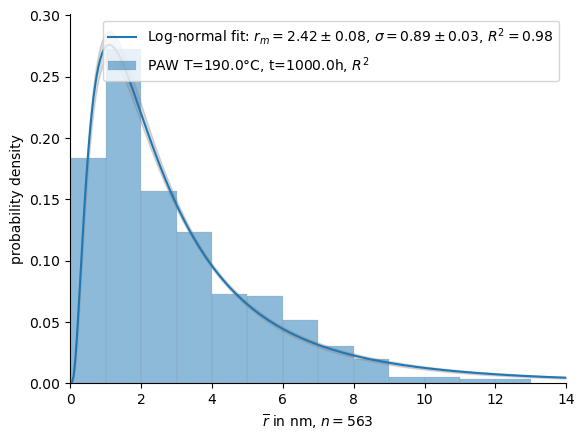

calculating distribution of T190.0°C_D8760.0hr_S0MPa with 540 polygons.
[0.01523384 0.01577303 0.01430151 0.01482379 0.0141195  0.01354753
 0.01002835 0.01061368 0.00581226 0.00609018 0.00412926 0.00451914
 0.0026189  0.         0.0026189  0.00185357 0.         0.00185357
 0.         0.         0.         0.00185357 0.         0.00185357
 0.         0.        ]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 26
    # variables        = 2
    chi-square         = 0.00733746
    reduced chi-square = 3.0573e-04
    Akaike info crit   = -208.494348
    Bayesian info crit = -205.978155
    R-squared          = 0.90731447
[[Variables]]
    sigma:  1.03970495 +/- 0.05764590 (5.54%) (init = 1)
    rm:     3.60045281 +/- 0.26972052 (7.49%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5848


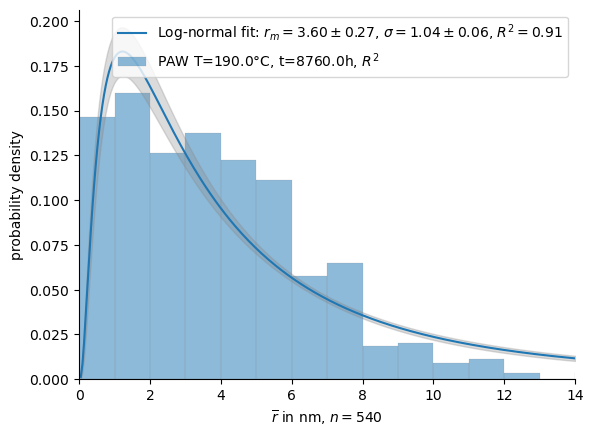

calculating distribution of T23.0°C_D0.0hr_S0MPa with 1518 polygons.
[0.01043859 0.01283727 0.00902362 0.00628133 0.00488242 0.00368943
 0.00292852 0.00207768 0.00174004 0.00114063 0.         0.        ]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 35
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00182723
    reduced chi-square = 1.8272e-04
    Akaike info crit   = -101.478322
    Bayesian info crit = -100.508509
    R-squared          = 0.99222653
[[Variables]]
    sigma:  0.52882813 +/- 0.01282197 (2.42%) (init = 1)
    rm:     1.41984470 +/- 0.03088232 (2.18%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.7209


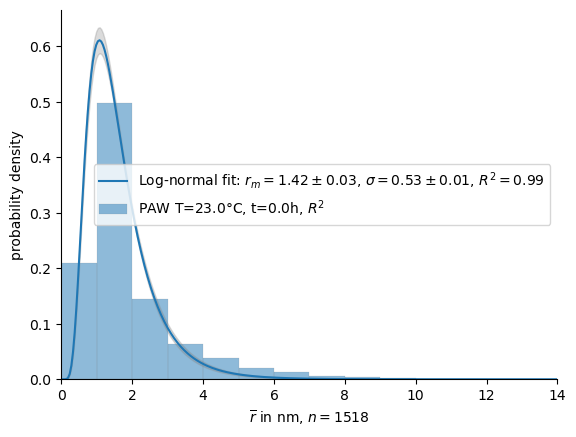

calculating distribution of T190.0°C_D25000.0hr_S0MPa with 363 polygons.
[0.02342786 0.02130143 0.01307679 0.01357043 0.0117209  0.01142491
 0.01357043 0.01080277 0.01080277 0.00861407 0.0047648  0.00613418
 0.00613418 0.0047648  0.00389586 0.00389586 0.         0.00389586
 0.00275861 0.00389586 0.0047648  0.00389586 0.         0.
 0.         0.         0.00275861 0.00275861 0.         0.00275861]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 30
    # variables        = 2
    chi-square         = 0.00572078
    reduced chi-square = 2.0431e-04
    Akaike info crit   = -252.945436
    Bayesian info crit = -250.143041
    R-squared          = 0.94788094
[[Variables]]
    sigma:  1.39412103 +/- 0.08835793 (6.34%) (init = 1)
    rm:     2.68774434 +/- 0.16777711 (6.24%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.3992


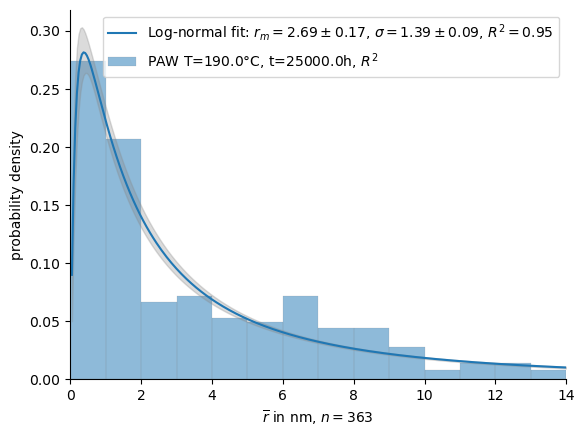

calculating distribution of T190.0°C_D2500.0hr_S0MPa with 621 polygons.
[0.01442473 0.01593938 0.01514174 0.01248737 0.01180277 0.0106466
 0.00988174 0.00889935 0.00727653 0.00425    0.00506725 0.00359777
 0.00322056 0.00279135 0.0016142  0.0016142  0.         0.0016142
 0.         0.         0.        ]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 21
    # variables        = 2
    chi-square         = 0.00164162
    reduced chi-square = 8.6401e-05
    Akaike info crit   = -194.588414
    Bayesian info crit = -192.499369
    R-squared          = 0.97897230
[[Variables]]
    sigma:  0.98399056 +/- 0.02680191 (2.72%) (init = 1)
    rm:     3.11525973 +/- 0.10896732 (3.50%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5872


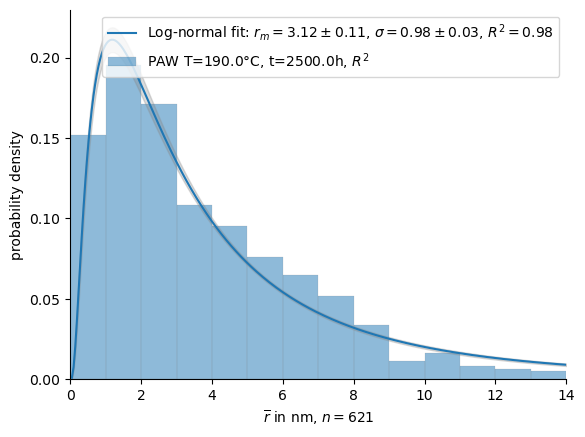

calculating distribution of T190.0°C_D250.0hr_S0MPa with 722 polygons.
[0.01529929 0.01692066 0.01344075 0.00954816 0.00988589 0.00852512
 0.00766976 0.00565077 0.00596544 0.0036517  0.0036517  0.00195874
 0.001386   0.001386   0.         0.00195874 0.00239729 0.00195874
 0.001386   0.00195874 0.00195874 0.001386  ]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 28
    # data points      = 22
    # variables        = 2
    chi-square         = 0.00304265
    reduced chi-square = 1.5213e-04
    Akaike info crit   = -191.493533
    Bayesian info crit = -189.311448
    R-squared          = 0.97597959
[[Variables]]
    sigma:  0.88456101 +/- 0.02822750 (3.19%) (init = 1)
    rm:     2.18354476 +/- 0.07518593 (3.44%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.6363


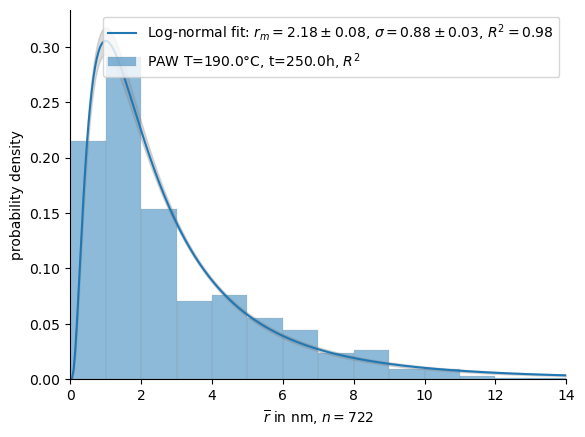

calculating distribution of T190.0°C_D5000.0hr_S0MPa with 1008 polygons.
[0.01474478 0.01375646 0.00942452 0.00837419 0.00779871 0.00664722
 0.00552756 0.00450302 0.00327553 0.00171745 0.00242521 0.00171745
 0.00261821 0.00140299 0.00261821 0.00140299 0.00198215 0.00140299
 0.002215   0.00198215 0.00198215 0.0029658  0.00099256 0.00140299
 0.00171745 0.00099256 0.         0.00099256 0.00099256 0.
 0.         0.00099256 0.         0.         0.         0.
 0.         0.         0.         0.00099256 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 34
    # data points      = 59
    # variables        = 2
    chi-square         = 0.00291995
    reduced chi-square = 5.1227e-05
    Akaike info crit   = -580.909805
    Bayesian info crit = -576.754730


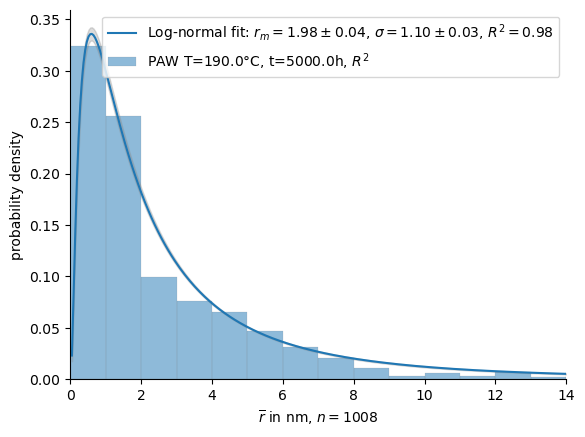

,temp,aging_time,stress,rois,chi squared,Rsquared,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,n_bins,dof,chi squared re,start,end,bin_width
dataset,,,,,,,,,,,,,,,,,,
T23.0°C_D0.0hr_S0MPa,23.0,0.0,0.0,https://metadata.omero.matolab.org/api/rois/51...,0.298517,0.992227,1.419845,0.030882,0.528828,0.012822,1.632932,0.035517,12,10,0.029852,0,14.0,1.0
T190.0°C_D250.0hr_S0MPa,190.0,250.0,0.0,https://metadata.omero.matolab.org/api/rois/72...,0.052869,0.975980,2.183545,0.075186,0.884561,0.028227,3.229004,0.111184,22,20,0.002643,0,14.0,1.0
T190.0°C_D1000.0hr_S0MPa,190.0,1000.0,0.0,https://metadata.omero.matolab.org/api/rois/83...,0.029115,0.982964,2.416129,0.082879,0.887480,0.026335,3.582200,0.122877,13,11,0.002647,0,14.0,1.0
T190.0°C_D2500.0hr_S0MPa,190.0,2500.0,0.0,https://metadata.omero.matolab.org/api/rois/86...,0.063273,0.978972,3.115260,0.108967,0.983991,0.026802,5.055270,0.176826,21,19,0.003330,0,14.0,1.0
T190.0°C_D5000.0hr_S0MPa,190.0,5000.0,0.0,https://metadata.omero.matolab.org/api/rois/11...,0.094791,0.983557,1.975461,0.041459,1.096964,0.027424,3.605524,0.075669,59,57,0.001663,0,14.0,1.0
T190.0°C_D8760.0hr_S0MPa,190.0,8760.0,0.0,https://metadata.omero.matolab.org/api/rois/26...,0.170905,0.907314,3.600453,0.269721,1.039705,0.057646,6.181450,0.463071,26,24,0.007121,0,14.0,1.0
T190.0°C_D25000.0hr_S0MPa,190.0,25000.0,0.0,https://metadata.omero.matolab.org/api/rois/14...,0.128197,0.947881,2.687744,0.167777,1.394121,0.088358,7.102800,0.443378,30,28,0.004578,0,14.0,1.0


In [17]:
#ignoring zero division for fit, cause it can happen while iterating
np.seterr(divide='ignore',invalid='ignore')
# create histogram and fit distrbution to found polygon areas
fits=list()
for dataset, content in poly_dict.items():
    dataframe=content['dataframe']
    props=dataset.split('_')
    temp=float(props[0][1:-2])
    aging_time=float(props[1][1:-2])
    stress=float(props[2][1:-3])
    #print(temp,aging_time,stress)
    print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
    #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)

    histogram=get_histogram(dataframe['mean_radius_circle_area'])
    #remive all special chars
    filename=''.join(e for e in dataset if e.isalnum())
    filename="images/{}.png".format(filename)
    xlabel=r"$\overline{r}$ in nm, $n=$"+str(len(dataframe))
    tmp=dataset.split('_')
    label=r"PAW T={}, t={}".format(tmp[0][1:],tmp[1][1:-1])
    print(histogram['norm_err'].values)
    weights=None
    record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'], weights, label=label, x_min=0.0, x_max=14.0, x_label=xlabel, filename=filename,save_plot=True)}
    record.pop('fit')
    fits.append({**{'dataset': dataset, "temp": temp, "aging_time": aging_time, "stress": stress, "rois": " ".join(content['rois'])},**record})
fit_results=pd.DataFrame(fits).set_index('dataset')
fit_results.sort_values('aging_time',inplace=True)
fit_results.to_csv('fit_results.csv')
fit_results

In [98]:
# annotate fit_results.csv
response=annotate_csv_uri("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.csv")

csvw annotation file created, suggested name: fit_results-metadata.json
wrote csvw meta data to fit_results-metadata.json


In [99]:
# serialize table to rdf, uses already commited files on main branch
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
response=csvw_to_rdf(meta_url)

writen serialized table to fit_results.ttl


In [94]:
# create a rule bases mapping between the data in detection_runs and the precipitate analysis knowledge graph 
meta_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-metadata.json"
method_url="https://github.com/BAMresearch/DF-TEM-PAW/raw/main/StatisticalAnalysisWorkflow.ttl"
use_template_rowwise=True
d_classes= [
    "http://www.w3.org/ns/oa#Annotation",''
    "http://www.w3.org/ns/csvw#Column"
]
m_classes=["https://w3id.org/pmd/co/ValueObject",]
pred="https://w3id.org/pmd/co/isResourceOf"
map_dict={
    "precipitateRegions": "table-1-Rois",
    "ImageSetName": "table-1-Dataset",
    "binWidth": "table-1-BinWidth",
    "x-Max": "table-1-End",
    "x-Min": "table-1-Start",
    "chisqrd": "table-1-ChiSquared",
    "r_a": "table-1-Ra",
    "r_m": "table-1-Rm",
    "sigma": "table-1-Sigma",
    "stderr_r_a": "table-1-RmStderr",
    "stderr_r_a": "table-1-RaStderr",
    "stderr_sigma": "table-1-SigmaStderr",
}
create_mapping(meta_url=meta_url,method_url=method_url,use_template_rowwise=use_template_rowwise,data_super_classes=d_classes,predicate=pred,method_super_classes=m_classes,map_dict=map_dict)

writen mapping file to fit_results-map.yaml


True

In [2]:
# join all data and replicate template knowledge graph for every row in table
mapping_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results-map.yaml"
data_url = "https://github.com/BAMresearch/DF-TEM-PAW/raw/main/fit_results.ttl"
duplicate_for_table = True
get_joined_rdf(map_url=mapping_url,data_url=data_url,duplicate_for_table=duplicate_for_table)


applied 11 mapping rules and skipped 0
wrote joint graph to fit_results-joined.ttl


In [4]:
#merge all metadata together
df_graph=Graph()
df_graph.parse("https://raw.githubusercontent.com/BAMresearch/DF-TEM-PAW/main/detection_runs-joined.ttl",format='turtle')
df_graph.parse("https://raw.githubusercontent.com/BAMresearch/DF-TEM-PAW/main/fit_results-joined.ttl",format='turtle')
df_graph.serialize('./df-tem-paw-all.ttl',format='turtle')

<Graph identifier=N59bf5d94f78f4635a6a5b410c85a3dd9 (<class 'rdflib.graph.Graph'>)>

Rock_T23.0°C_D0.0hr_S0MPa
calculating distribution of Rock_T23.0°C_D0.0hr_S0MPa with 1733 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 13
    # variables        = 2
    chi-square         = 6.2978e-04
    reduced chi-square = 5.7253e-05
    Akaike info crit   = -125.156149
    Bayesian info crit = -124.026250
    R-squared          = 0.99738539
[[Variables]]
    sigma:  0.53751371 +/- 0.00661926 (1.23%) (init = 1)
    rm:     1.52657672 +/- 0.01861596 (1.22%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5938


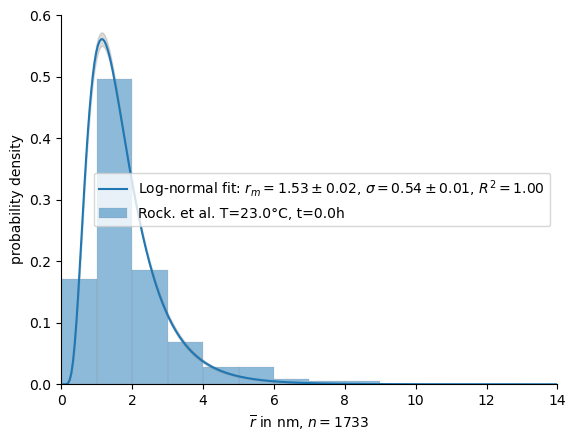

Rock_T190.0°C_D250.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D250.0hr_S0MPa with 710 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00198830
    reduced chi-square = 1.8075e-04
    Akaike info crit   = -110.210547
    Bayesian info crit = -109.080649
    R-squared          = 0.98163285
[[Variables]]
    sigma:  0.78856818 +/- 0.02396496 (3.04%) (init = 1)
    rm:     2.08473809 +/- 0.06899177 (3.31%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.6052


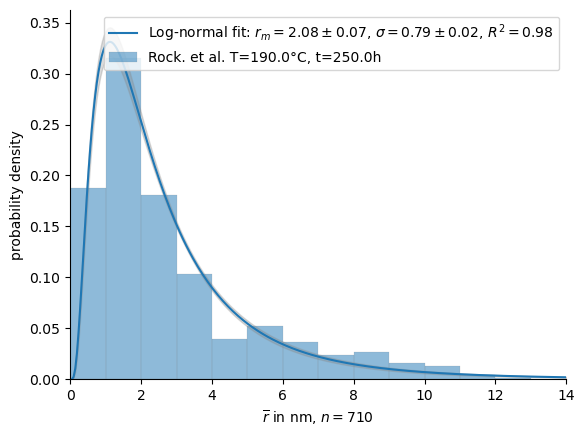

Rock_T190.0°C_D1000.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D1000.0hr_S0MPa with 306 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00364109
    reduced chi-square = 3.3101e-04
    Akaike info crit   = -102.345469
    Bayesian info crit = -101.215570
    R-squared          = 0.94036669
[[Variables]]
    sigma:  0.88320926 +/- 0.04303576 (4.87%) (init = 1)
    rm:     2.96804911 +/- 0.17825519 (6.01%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.5193


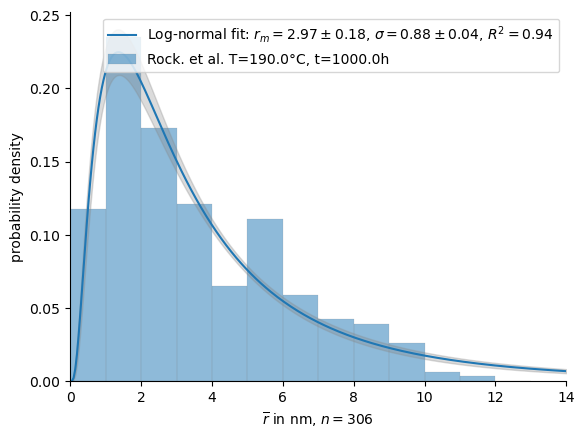

Rock_T190.0°C_D2500.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D2500.0hr_S0MPa with 358 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00258579
    reduced chi-square = 2.3507e-04
    Akaike info crit   = -106.794740
    Bayesian info crit = -105.664841
    R-squared          = 0.95396653
[[Variables]]
    sigma:  0.74318013 +/- 0.03659610 (4.92%) (init = 1)
    rm:     3.56286546 +/- 0.15601430 (4.38%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2485


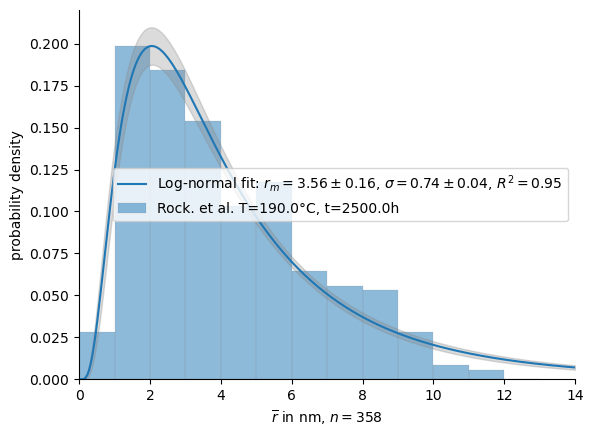

Rock_T190.0°C_D5000.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D5000.0hr_S0MPa with 331 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00254425
    reduced chi-square = 2.3130e-04
    Akaike info crit   = -107.005303
    Bayesian info crit = -105.875404
    R-squared          = 0.95146454
[[Variables]]
    sigma:  0.65197598 +/- 0.03368938 (5.17%) (init = 1)
    rm:     3.97463648 +/- 0.15153593 (3.81%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2686


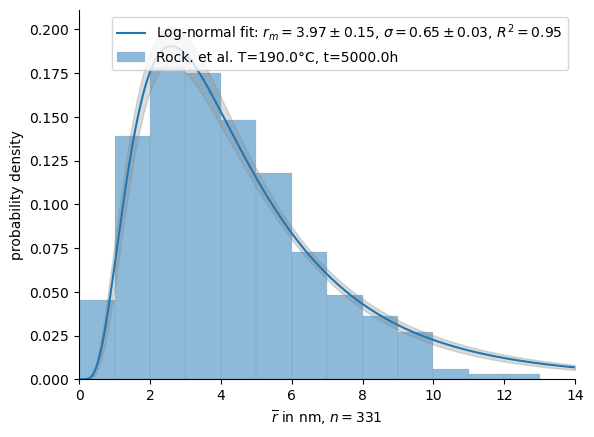

Rock_T190.0°C_D8760.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D8760.0hr_S0MPa with 300 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 44
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00428678
    reduced chi-square = 3.8971e-04
    Akaike info crit   = -100.223180
    Bayesian info crit = -99.0932812
    R-squared          = 0.92738261
[[Variables]]
    sigma:  0.39858107 +/- 0.02499908 (6.27%) (init = 1)
    rm:     5.64148733 +/- 0.17035383 (3.02%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.1759


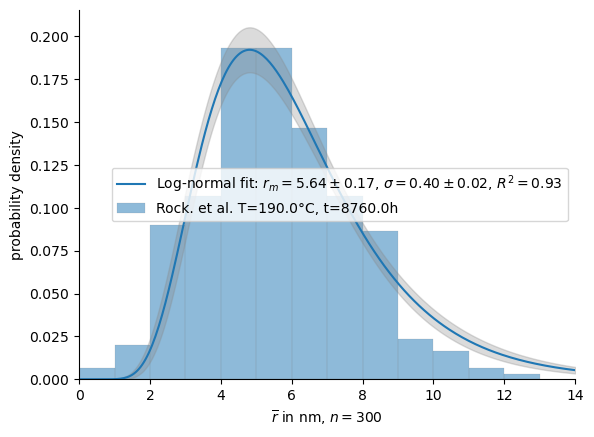

Rock_T190.0°C_D25000.0hr_S0MPa
calculating distribution of Rock_T190.0°C_D25000.0hr_S0MPa with 188 polygons.
[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 38
    # data points      = 13
    # variables        = 2
    chi-square         = 0.00548907
    reduced chi-square = 4.9901e-04
    Akaike info crit   = -97.0092950
    Bayesian info crit = -95.8793963
    R-squared          = 0.87061869
[[Variables]]
    sigma:  0.38056423 +/- 0.03072089 (8.07%) (init = 1)
    rm:     7.18560942 +/- 0.26623835 (3.71%) (init = 5)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = +0.2093


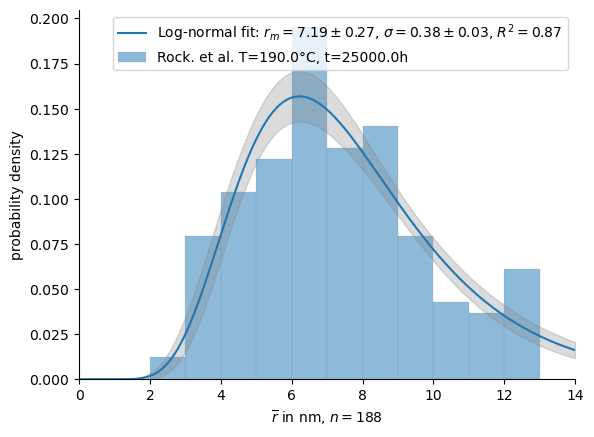

,temp,aging_time,stress,chi squared,Rsquared,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,n_bins,dof,chi squared re,start,end,bin_width
dataset,,,,,,,,,,,,,,,,,
Rock_T23.0°C_D0.0hr_S0MPa,23.0,0.0,0.0,0.113050,0.997385,1.526577,0.018616,0.537514,0.006619,1.763831,0.021509,13,11,0.010277,0,14.0,1.0
Rock_T190.0°C_D250.0hr_S0MPa,190.0,250.0,0.0,0.056097,0.981633,2.084738,0.068992,0.788568,0.023965,2.845000,0.094152,13,11,0.005100,0,14.0,1.0
Rock_T190.0°C_D1000.0hr_S0MPa,190.0,1000.0,0.0,0.076108,0.940367,2.968049,0.178255,0.883209,0.043036,4.383880,0.263287,13,11,0.006919,0,14.0,1.0
Rock_T190.0°C_D2500.0hr_S0MPa,190.0,2500.0,0.0,0.057094,0.953967,3.562865,0.156014,0.743180,0.036596,4.696058,0.205636,13,11,0.005190,0,14.0,1.0
Rock_T190.0°C_D5000.0hr_S0MPa,190.0,5000.0,0.0,0.210059,0.951465,3.974636,0.151536,0.651976,0.033689,4.915874,0.187421,13,11,0.019096,0,14.0,1.0
Rock_T190.0°C_D8760.0hr_S0MPa,190.0,8760.0,0.0,2360.809893,0.927383,5.641487,0.170354,0.398581,0.024999,6.107889,0.184438,13,11,214.619081,0,14.0,1.0
Rock_T190.0°C_D25000.0hr_S0MPa,190.0,25000.0,0.0,0.082728,0.870619,7.185609,0.266238,0.380564,0.030721,7.725256,0.286233,13,11,0.007521,0,14.0,1.0


In [11]:
# reproduce original data
datasets={
    'Rock_T23.0°C_D0.0hr_S0MPa': "./original_data/RockT61.csv",
    'Rock_T190.0°C_D250.0hr_S0MPa': "./original_data/T1900CD2500hrS0MPa.csv",
    'Rock_T190.0°C_D1000.0hr_S0MPa': "./original_data/T1900CD10000hrS0MPa.csv",
    'Rock_T190.0°C_D2500.0hr_S0MPa': "./original_data/T1900CD25000hrS0MPa.csv",
    'Rock_T190.0°C_D5000.0hr_S0MPa': "./original_data/T1900CD50000hrS0MPa.csv",
    'Rock_T190.0°C_D8760.0hr_S0MPa': "./original_data/T1900CD87600hrS0MPa.csv",
    'Rock_T190.0°C_D25000.0hr_S0MPa': "./original_data/T1900CD250000hrS0MPa.csv"
    }
#readin data
for dataset, file in datasets.items():
    df=pd.read_csv(file,sep=';',encoding='utf-8',decimal=',')
    datasets[dataset]=df


#ignoring zero division for fit, cause it can happen while iterating
np.seterr(divide='ignore',invalid='ignore')
# create histogram and fit distrbution to found polygon areas
fits=list()
for dataset, dataframe in datasets.items():
    print(dataset)
    props=dataset.split('_')
    temp=float(props[1][1:-2])
    aging_time=float(props[2][1:-2])
    stress=float(props[3][1:-3])
    #dataframe.plot('Radius [nm]')
    print("calculating distribution of {} with {} polygons.".format(dataset, len(dataframe)))
    #histogram=get_histogram(dataframe['mean_radius_circle_area'],plot_result=True)
    histogram=get_histogram(dataframe['Radius [nm]'],end=14.0)
    #remive all special chars
    filename=''.join(e for e in dataset if e.isalnum())
    filename="images/{}.png".format(filename)
    xlabel=r"$\overline{r}$ in nm"+r", $n=${}".format(len(dataframe))
    tmp=dataset.split('_')
    label="Rock. et al. T={}, t={}".format(tmp[1][1:],tmp[2][1:-1])
    weights=None
    record={**{'dataset': dataset, "temp": temp, "aging_time": aging_time, "stress": stress},**fit_log_distribution(histogram['center'],histogram['norm'], weights, label=label, x_min=0.0, x_max=14.0, x_label=xlabel, filename=filename,save_plot=True)}
    #record={**{'dataset': dataset},**fit_log_distribution(histogram['center'],histogram['norm'])}
    record.pop('fit')
    fits.append({**{'dataset': dataset},**record})
fit_results=pd.DataFrame(fits).set_index('dataset')
fit_results.sort_values('aging_time',inplace=True)
fit_results.to_csv('org_fit_results.csv')
fit_results

                          dataset   temp  aging_time    rm  rm stderr  sigma  \
0       Rock_T23.0°C_D0.0hr_S0MPa   23.0         0.0  1.56       0.04   0.52   
1    Rock_T190.0°C_D250.0hr_S0MPa  190.0       250.0  2.03       0.08   0.70   
2   Rock_T190.0°C_D1000.0hr_S0MPa  190.0      1000.0  3.05       0.30   0.91   
3   Rock_T190.0°C_D2500.0hr_S0MPa  190.0      2500.0  3.63       0.27   0.80   
4   Rock_T190.0°C_D5000.0hr_S0MPa  190.0      5000.0  4.04       0.38   0.78   
5   Rock_T190.0°C_D8760.0hr_S0MPa  190.0      8760.0  5.64       0.20   0.41   
6  Rock_T190.0°C_D25000.0hr_S0MPa  190.0     25000.0  7.36       0.21   0.42   

   sigma stderr    ra  ra stderr  
0          0.01  1.79       0.05  
1          0.03  2.61       0.12  
2          0.06  4.65       0.53  
3          0.05  5.00       0.52  
4          0.07  5.50       0.60  
5          0.03  6.14       0.23  
6          0.02  8.03       0.25  
                          dataset   temp  aging_time  stress  chi squared  \
0 

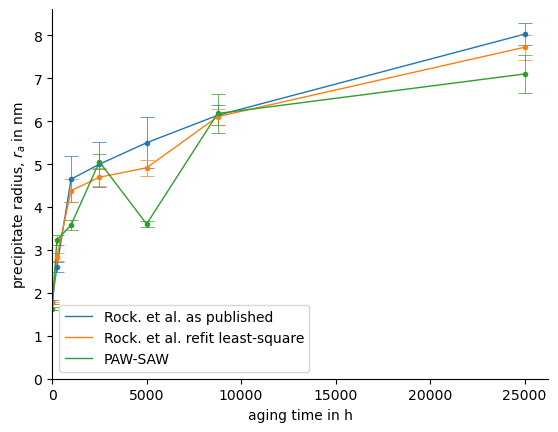

In [4]:
#compare results
datasets={
    'Rock. et al. as published': "./rock_org.csv",
    'Rock. et al. refit least-square': "./org_fit_results.csv",
    'PAW-SAW': "./fit_results.csv",
    #'PAW-SAW aspect ratio < 3': "./fit_results_filtered.csv"
    }
#readin data
for dataset, file in datasets.items():
    df=pd.read_csv(file)
    #print(dataset, df)
    datasets[dataset]=df

org_results_rm =[1.79, 2.61, 4.66, 5.0, 5.5, 6.14, 8.03]
org_results_rm_stderr =[0.05, 0.12, 0.53, 0.42, 0.6, 0.23, 0.25]


fig=plt.figure()
#plt.title(r"results comparison")
   
filename="./images/compare_results.png"
plt.tight_layout()
ax=plt.axes()
#    #ax.set_facecolor((.94, .94, .94))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#line,=ax.plot(datasets[list(datasets.keys())[0]]['aging_time'], org_results_rm,marker='o', label='Rock. et al. simplex')
#ax.errorbar(datasets[list(datasets.keys())[0]]['aging_time'], org_results_rm, yerr=org_results_rm_stderr, fmt="o", color=line.get_color())
for dataset, dataframe in datasets.items():
#    #ax.yaxis.grid(True, color='#EEEEEE')
#    #ax.xaxis.grid(False)
    print(dataframe)
    line,=ax.plot(dataframe['aging_time'], dataframe['ra'], marker='',linewidth=1, label=dataset)
    ax.errorbar(dataframe['aging_time'], dataframe['ra'], yerr=dataframe['ra stderr'], fmt="o", markersize=3, linewidth=0.5, color=line.get_color(),capsize=5, capthick=0.5)
#    plt.plot(fit['x'], fit['y'], label='fit')
#    plt.fill_between(fit['x'], fit['y']-fit['dely'],
#          fit['y']+fit['dely'], color='#888888',alpha=0.3)
plt.xlabel('aging time in h')
#    plt.xlim(left=x_min,right=x_max)
#    plt.ylim(bottom=0)
#    bar_color = bars[0].get_facecolor()
#    if y_max:
#       plt.ylim(top=y_max)
   
#    #plt.xticks(x)
plt.ylabel(r"precipitate radius, $r_a$ in nm")
plt.xlim(left=0.0)
plt.ylim(bottom=0.0)
plt.legend()

plt.show()
   
fig.savefig(filename)
plt.close(fig)   

